# VLM for KOMO

In [11]:
import time
import torch
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt

import mess_utils
from high_level_funcs import RobotEnviroment
from Robotic_Manipulation.shelf import generate_shelf
from utils import generate_blocks_scene, cleanup_highlvl_func

In [12]:
torch.cuda.empty_cache()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

Using cpu


## Prepare your scene

In [14]:
C = ry.Config()
C.addFile(ry.raiPath('../rai-robotModels/scenarios/pandaSingle.g'))

C.delFrame("panda_collCameraWrist")
C.getFrame("table").setShape(ry.ST.ssBox, size=[1., 1., .1, .02])

# Shelf
pos = np.array([-1., 0., .5])
generate_shelf(C, pos)

names = ["red", "green", "blue"]

# Objects
for i in range(3):
	color = [0., 0., 0.]
	color[i%3] = 1.
	C.addFrame(f"block_{names[i]}") \
		.setPosition([(i%3)*.15, (i//3)*.1+.1, .71]) \
		.setShape(ry.ST.ssBox, size=[.04, .04, .12, 0.005]) \
		.setColor(color) \
		.setContact(1) \
		.setMass(.1)
	
# for convenience, a few definitions:
gripper = "l_gripper"
palm = "l_palm"
table = "table"
box = "box0"

C.view(True)

13

## Prepare your VLM

In [15]:
# from prompting import prompt_qwen
# from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype="auto",
#     device_map=device
# )
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

## Take a picture of the scene

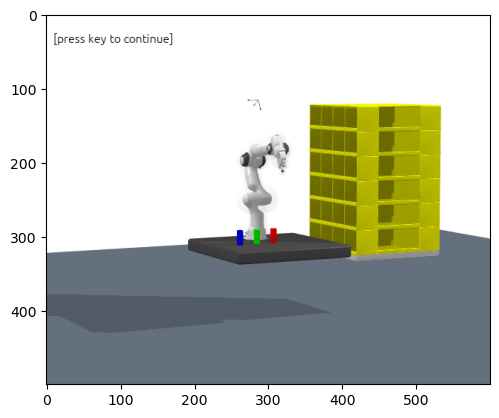

In [16]:
# camera_frame = C.getFrame('cameraTop')
# print(camera_frame)
# C.view_setCamera(camera_frame)
# C.view()
# time.sleep(1.)

rgb = C.view_getRgb()
depth = C.view_getDepth()

img_idx = 0
image_path = "../scene_image0.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

## Prepare initial prompt

In [17]:
task_description = "Build a bridge. A bridge is defined as two parallel blocks, and one horizontal block on top of them. Make sure that the two parallel blocks have an appropriate distance to each other, such that the horizontal block can be placed on top. Also make sure that the yaw and up_vec of the horizontal block make sense"

with open("./prompts/abstract_primitives/abstract_primitives_tutorial.txt", 'r') as file:
    high_tutorial = file.read()

with open("./prompts/problem_definition.txt", 'r') as file:
    problem_definition = file.read()

frame_names = [line for line in C.getFrameNames() if not line.startswith("l_") and not line.startswith("small_") and not line.startswith("shelf_") and not line.startswith("big_")]

global_text = f"{high_tutorial}\n{problem_definition}"
task_specific_text = f"{task_description}\nHere is a list of all available object names: {frame_names}"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": global_text,
            },
            {
                "type": "image",
                "image": image_path,
            },
            {
                "type": "text",
                "text": task_specific_text,
            },
        ],
    },
]
full_text = f"{global_text}\n{task_specific_text}"
print(full_text)

The following text defines abstract primitive functions which are well defined already. You can use them for manipulating the robot arm as you like

pick(object_name: str)
- Generates a motion plan to pick an object
- Parameters:
  - object_name (str): The frame name of the object to be picked.

place(x: float, y: float, z: float=.0, up_vec: str="z", yaw: float=None)
- Generates a place motion of the robot's object in hand
- Parameters:
  - x (float): Target position on the x axis.
  - y (float): Target position on the y axis.
  - z (float)(default: 0): Target position on the z axis, if 0 it will be on top of the table.
  - up_vec (str)(default: z): The vector in coordinate frame of the object to be pointing upward in the world frame, that is the vector in the object frame to be parallel to the world frame z vector.
  - yaw (float)(optional): The angle of rotation of the object with respect to it's up vector.

push(object_name: str, relative_x: float, relative_y: float)
- Generates a m

## Main loop

In [18]:
# raw_out = prompt_qwen(model, processor, device, messages)

raw_out = """def solve():
    block_red = getObj('block_red')
    block_green = getObj('block_green')
    block_blue = getObj('block_blue')
    
    y_pos = block_blue.pos.y
    
    # Distance between pillars: centers spaced by (top_block_length + pillar_width)
    distance_between_centers = block_blue.size.x + block_red.size.x
    pillar1_x = -distance_between_centers / 2
    pillar2_x = distance_between_centers / 2
    
    # Place pillars (vertical, up_vec="z")
    pick('block_red')
    place(x=pillar1_x, y=y_pos, z=0.0, up_vec='z')
    pick('block_green')
    place(x=pillar2_x, y=y_pos, z=0.0, up_vec='z')
    
    # Top block height: tallest pillar height + half top block thickness (now along y-axis)
    max_pillar_height = max(block_red.size.z, block_green.size.z)
    top_block_z = max_pillar_height + block_blue.size.y / 2
    
    # Place top block horizontally (up_vec="y" to align local y with world z)
    pick('block_blue')
    place(x=0.0, y=y_pos, z=top_block_z, up_vec='y', yaw=0.0)
"""

raw_out = """def build_bridge():
    # Get object parameters
    red_block = getObj("block_red")
    green_block = getObj("block_green")
    blue_block = getObj("block_blue")

    # Calculate spacing for the two vertical blocks
    # Use the size of the blue block to calculate appropriate spacing
    spacing_x = blue_block.size.y + red_block.size.x  # Ensure the blue block fits snugly

    # Place the first vertical block (red block)
    pick("block_red")
    place(x=red_block.pos.x, y=red_block.pos.y, z=0, up_vec="z")

    # Place the second vertical block (green block)
    pick("block_green")
    place(x=red_block.pos.x + spacing_x, y=red_block.pos.y, z=0, up_vec="z")

    # Place the horizontal block (blue block) on top
    pick("block_blue")
    # Calculate the center position for the horizontal block
    center_x = red_block.pos.x + spacing_x / 2
    center_y = red_block.pos.y
    # Correctly position the blue block's center
    top_z = red_block.size.z + (blue_block.size.x / 2)  # Adjust for the rotated block's height
    # Rotate the blue block so it lies flat horizontally
    place(x=center_x, y=center_y, z=top_z, up_vec="x", yaw=0)
"""

out = cleanup_highlvl_func(raw_out, compute_collisions=False)
print(out)

exec(out)

def build_bridge():
    env = RobotEnviroment(C, visuals=True, verbose=1, compute_collisions=False)
    # Get object parameters
    red_block = env.getObj("block_red")
    green_block = env.getObj("block_green")
    blue_block = env.getObj("block_blue")

    # Calculate spacing for the two vertical blocks
    # Use the size of the blue block to calculate appropriate spacing
    spacing_x = blue_block.size.y + red_block.size.x  # Ensure the blue block fits snugly

    # Place the first vertical block (red block)
    env.pick("block_red")
    env.place(x=red_block.pos.x, y=red_block.pos.y, z=0, up_vec="z")

    # Place the second vertical block (green block)
    env.pick("block_green")
    env.place(x=red_block.pos.x + spacing_x, y=red_block.pos.y, z=0, up_vec="z")

    # Place the horizontal block (blue block) on top
    env.pick("block_blue")
    # Calculate the center position for the horizontal block
    center_x = red_block.pos.x + spacing_x / 2
    center_y = red_block.pos.y
    # 

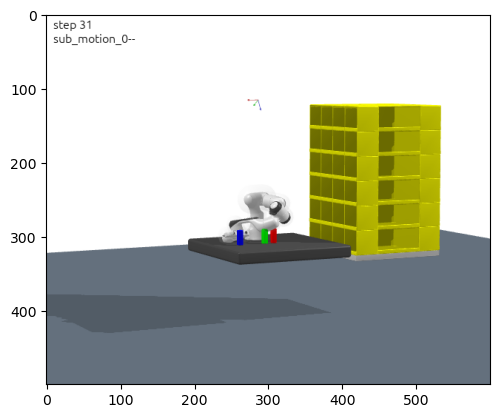

In [19]:
rgb = C.view_getRgb()
depth = C.view_getDepth()

img_idx = 0
result_img_path = "../scene_image1.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

In [20]:
messages.append(mess_utils.basic_struct("system", raw_out))
messages.append(
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": result_img_path,
            },
            {
                "type": "text",
                "text": "Here is a picture of the result of your motion. Was the problem solved successfully? If not fix your function."
            },
        ],
    },
)
# raw_out = prompt_qwen(model, processor, device, messages)